<a href="https://colab.research.google.com/github/haiderareeb/RandomForestLearning/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#requirements
!pip install pandas-profiling numpy matplotlib seaborn --quiet
!pip install opendatasets scikit-learn  --quiet --upgrade
!pip install plotly --quiet --upgrade
import plotly.express as px
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import os
%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',150)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 18.1 MB/s eta 0:00:00


In [4]:
#Data Gathering
from sklearn.datasets import load_iris
data = load_iris()
x, y = data.data, data.target

# Convert to a pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)

#add target col
df['species'] = y

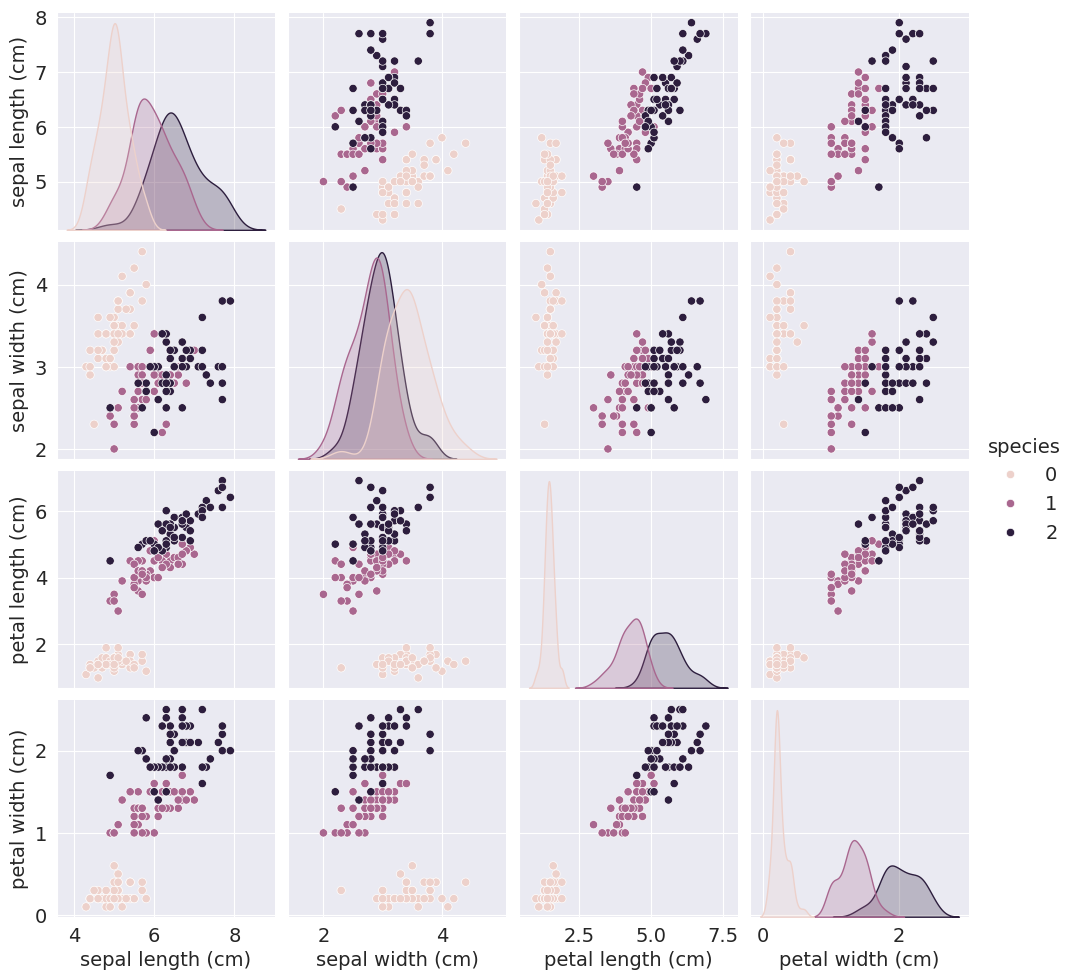

In [ ]:
# Data Analysis

# Plot using seaborn (it handles DataFrame columns easily)
sns.pairplot(df, hue='species', diag_kind='kde')
plt.show()

In [5]:
#Data Pre-processing
df.isna().sum()
df.duplicated().sum()

# cols
input_cols = data.feature_names
target_col = 'species'
categorical_cols = ['species']
numerical_cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

#split dataset
from sklearn.model_selection import train_test_split
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.3,random_state=42) #70% train, 30%temp
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.5,random_state=42) #50%validation,50% test

#creating inputs & outputs for each dataset
train_inputs = pd.DataFrame(x_train, columns=input_cols)
train_targets = pd.DataFrame(y_train, columns=[target_col]) # target_col should be in a list
val_inputs = pd.DataFrame(x_val, columns=input_cols)
val_targets = pd.DataFrame(y_val, columns=[target_col])  # target_col should be in a list
test_inputs = pd.DataFrame(x_test, columns=input_cols)
test_targets = pd.DataFrame(y_test, columns=[target_col])

# Since we're using NumPy arrays, you don't need to check for numerical and categorical columns here.

#Save processed data to disk
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
train_targets.to_parquet('train_targets.parquet')
val_targets.to_parquet('val_targets.parquet')
test_targets.to_parquet('test_targets.parquet')

In [12]:
#Model Training
from sklearn.ensemble import RandomForestClassifier
# n_jobs allows the random forest to use mutiple parallel workers to train decision trees
model = RandomForestClassifier(n_jobs=-1,random_state=42,max_depth=2,min_samples_leaf=5,min_samples_split=10).fit(train_inputs,train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [13]:
#testing the model performance
print("Training score: ", model.score(train_inputs,train_targets))
print("Validation score: ", model.score(val_inputs,val_targets))
print("Test score: ", model.score(test_inputs,test_targets))
train_probs = model.predict_proba(train_inputs)
# print("Training prob: ", train_probs)

Training score:  0.9333333333333333
Validation score:  1.0
Test score:  1.0


In [ ]:
#we can access individual decision trees using
model.estimators_[0]

from sklearn.tree import plot_tree
plt.figure(figsize=(80,20))
# Convert class names to strings before passing to plot_tree (class_names need string values to concatenate)
class_names_str = [str(c) for c in model.classes_]
# plot_tree(model.estimators_[0],max_depth=2,feature_names=train_inputs.columns,filled=True,rounded=True,class_names=class_names_str)

len(model.estimators_)

100

<Figure size 8000x2000 with 0 Axes>

<Axes: title={'center': 'Feature Importance'}, xlabel='importance', ylabel='feature'>

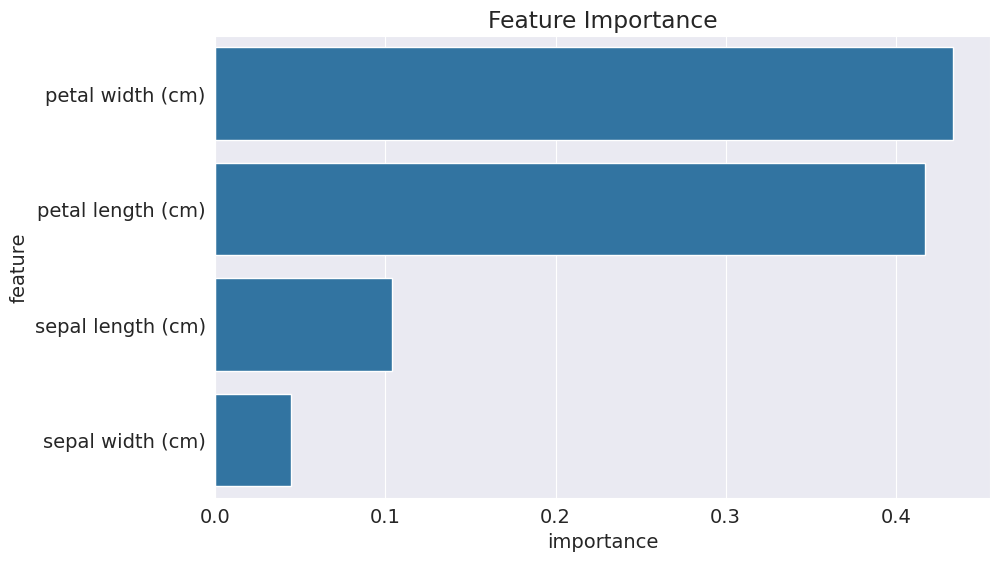

In [ ]:
#random forests also assign an "importance" to each feature, by combining the importance values from individual trees.
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance',y='feature')

In [ ]:
#Hyperparameter tuning with random forests
base_model = model
base_train_acc = base_model.score(train_inputs, train_targets)
base_val_acc = base_model.score(val_inputs, val_targets)
base_accs = base_train_acc, base_val_acc
print(f'Base model train acc: {base_train_acc:.4f}, val acc: {base_val_acc:.4f}')

Base model train acc: 1.0000, val acc: 1.0000


In [ ]:
#1) Hyperparamter: n_estimators: This argument controls the number of decision trees in the random forest. The default value is 100.
#  For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed.
#10 n_estimators
model1 = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42).fit(train_inputs,train_targets)
print('training score: ',model1.score(train_inputs,train_targets))
print('validation score: ',model1.score(val_inputs,val_targets))

training score:  1.0
validation score:  1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
#500 n_estimators
model2 = RandomForestClassifier(n_estimators=500,n_jobs=-1,random_state=42).fit(train_inputs,train_targets)
print('training score: ',model2.score(train_inputs,train_targets))
print('validation score: ',model2.score(val_inputs,val_targets))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


training score:  1.0
validation score:  1.0


In [ ]:
#2) max_depth and max_leaf_nodes: These arguments are passed directly to each decision tree, and control the maximum depth and max. no leaf nodes of each tree respectively. By default, no maximum depth is specified,
# which is why each tree has a training accuracy of 100%. You can specify a max_depth to reduce overfitting.

def test_params(**params):
    model3 = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    return model3.score(train_inputs, train_targets), model3.score(val_inputs, val_targets)

print(test_params(max_depth=5))
print(test_params(max_depth=26))
print(test_params(max_leaf_nodes=2**20))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


In [ ]:
#3) max_features: Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.
# Notice that the default value auto causes only sqrt(n) out of total features (n) to be chosen randomly at each split.
# This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees,
# so the random forest will not generalize well.

print(test_params(max_features='log2'))
print(test_params(max_features=3))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


In [ ]:
#4) min_samples_split and min_samples_leaf
# min_samples_leaf: Without min_samples_leaf, the tree might create leaf nodes with only a few samples. If a leaf has only 1 or 2 samples, the tree might classify those based on just those few points, which could lead to poor performance on unseen data.
# min_samples_split: Without min_samples_split, the tree might end up with many very small splits, leading to complex rules that perfectly fit the training data but perform poorly on unseen data.
print(test_params(min_samples_split=3, min_samples_leaf=2))
print(test_params(min_samples_split=100, min_samples_leaf=60))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(0.9619047619047619, 1.0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(0.3523809523809524, 0.2727272727272727)


In [ ]:
#5) bootstrap, max_samples
# bootstrapping: By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly,
# with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.
print(test_params(bootstrap=False))

#max_samples: When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using max_samples. This can further generalize the model.
print(test_params(max_samples=0.9)) #90% of the rows will be selected from the dataset

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)


In [ ]:
#6) class_weight
model.classes_
#class imbalance: class imbalance occurs when the classes in the target variable are not evenly distributed. For example, if you have a dataset with 90% of one class and only 10% of another class,
# a model trained on this data might be biased toward predicting the majority class.

# below code: the model automatically adjusts the weight of each class inversely proportional to its frequency in the dataset.
test_params(class_weight='balanced')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


(1.0, 1.0)

In [ ]:
#final model
model = RandomForestClassifier(n_jobs=-1,
                               random_state=42,
                               n_estimators=10,
                               max_features=7,
                               max_depth=30,
                               min_samples_split=10,
                               min_samples_leaf=5,
                               class_weight='balanced').fit(train_inputs,train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
model.score(train_inputs, train_targets), model.score(val_inputs, val_targets),model.score(test_inputs, test_targets)


(0.9619047619047619, 1.0, 1.0)